# Modifying the mask

## utils

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, mask):
    """
    Helper function to display a mask image in Colab.
    """
    # Ensure mask is a 2D array (H, W) for grayscale display
    if len(mask.shape) == 3:
        # If it's 3-channel, convert to grayscale
        # This might happen if it's an RGB image of a mask
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray', vmin=0, vmax=255) # Use grayscale colormap
    plt.title(title)
    plt.axis('off')
    plt.show()

def compare_masks(mask1, mask2, title1="Original Mask", title2="Processed Mask"):
    """
    Displays two masks side-by-side for comparison in Colab.
    
    Args:
        mask1 (np.array): The first mask to display (e.g., original).
        mask2 (np.array): The second mask to display (e.g., processed).
        title1 (str): The title for the first mask.
        title2 (str): The title for the second mask.
    """
    
    def _to_2d(mask):
        """Helper to ensure mask is 2D for grayscale display."""
        if mask is None:
            return np.zeros((100, 100), dtype=np.uint8) # Placeholder
            
        if len(mask.shape) == 3:
            # If it's 3-channel, convert to grayscale.
            # Assumes cv2 is available in the notebook's global scope.
            try:
                # This function will be defined in the notebook's global scope
                # so it will have access to the imported cv2 module.
                mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                return mask_gray
            except Exception as e:
                # Fallback if cv2 isn't available or it's not BGR
                print(f"Note: Could not convert 3-ch image, taking first channel. Error: {e}")
                return mask[:, :, 0]
        return mask

    mask1_2d = _to_2d(mask1)
    mask2_2d = _to_2d(mask2)

    # Set up the plot with 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the first mask
    # We use vmin=0, vmax=255 to ensure consistent brightness scaling
    ax1.imshow(mask1_2d, cmap='gray', vmin=0, vmax=255)
    ax1.set_title(title1)
    ax1.axis('off')
    
    # Display the second mask
    ax2.imshow(mask2_2d, cmap='gray', vmin=0, vmax=255)
    ax2.set_title(title2)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


## processing

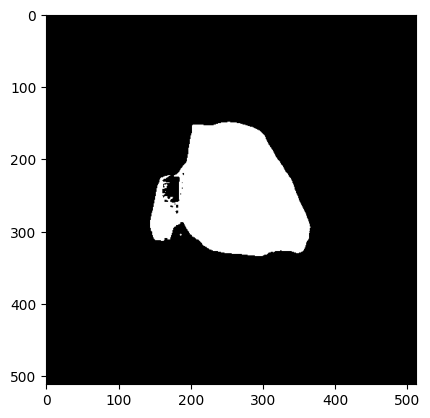

In [3]:
test_mask = cv2.imread("mask.png")
plt.imshow(test_mask)

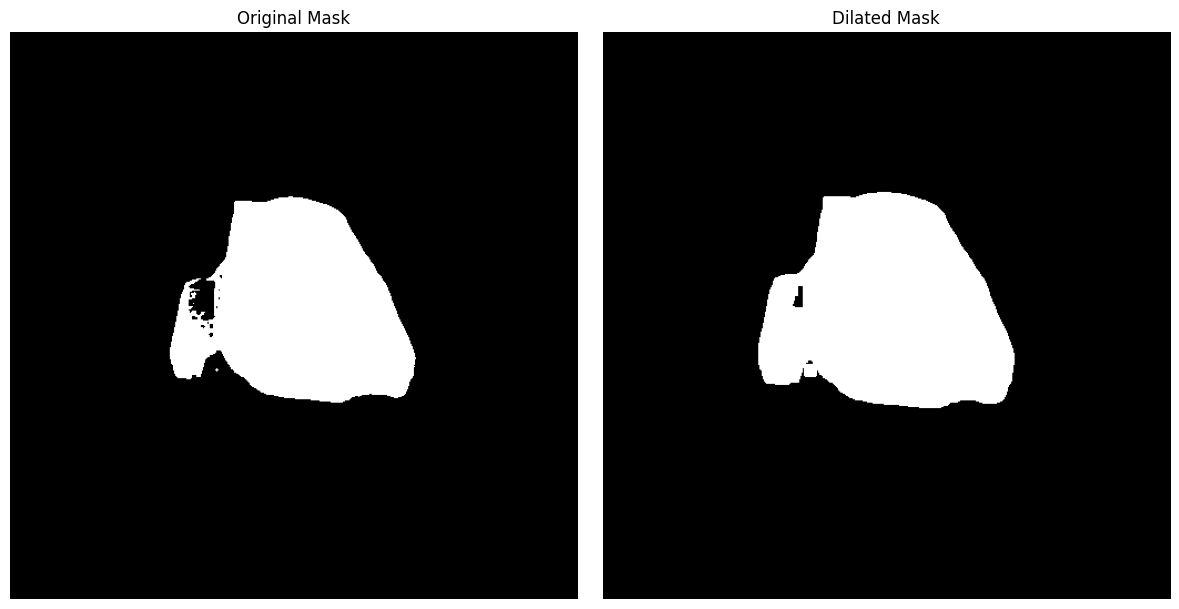

In [10]:
def dilate_mask(mask, kernel_size=5):
    """
    Increases the size of the foreground mask.
    
    Args:
        mask (np.array): The input binary mask (0s and 255s).
        kernel_size (int): The size of the square 'brush' to expand with.
                           Larger size = more dilation.
                           
    Returns:
        np.array: The dilated mask.
    """
    # A kernel defines the shape of the 'brush'
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # 'iterations=1' means we apply the operation once.
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    
    return dilated_mask

# --- Example Usage ---
dilated = dilate_mask(test_mask, kernel_size=10)
# show_image("Dilated Mask (Increased)", dilated)
compare_masks(test_mask, dilated, title2="Dilated Mask")

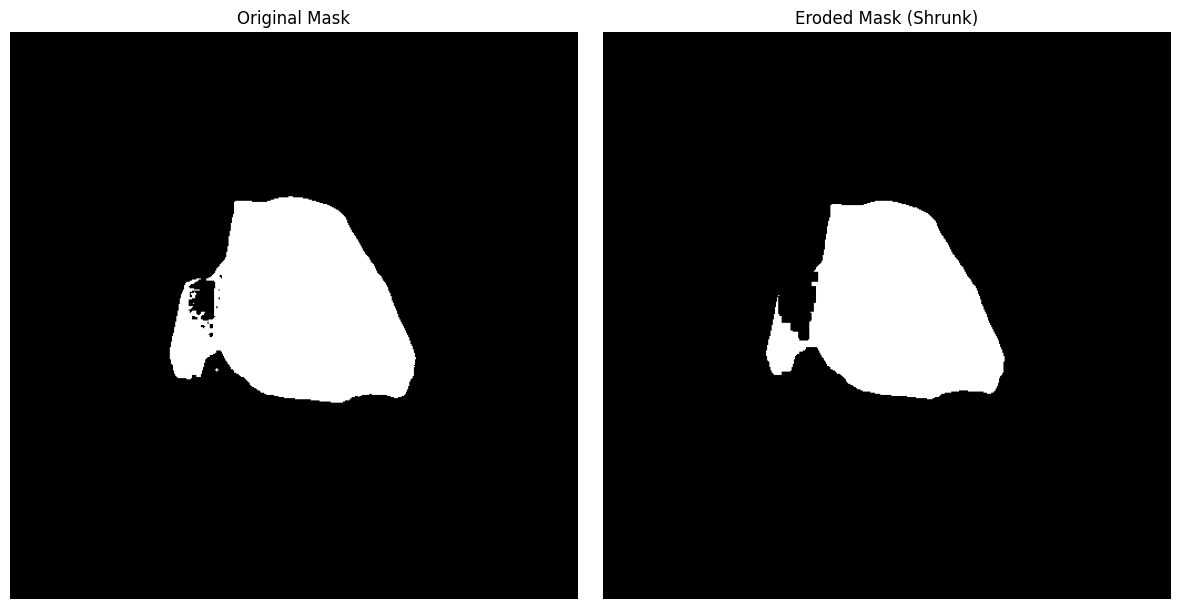

In [11]:
def erode_mask(mask, kernel_size=5):
    """
    Shrinks the size of the foreground mask.
    
    Args:
        mask (np.array): The input binary mask (0s and 255s).
        kernel_size (int): The size of the square 'brush' to shrink with.
                           Larger size = more erosion.
                           
    Returns:
        np.array: The eroded mask.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    return eroded_mask

# --- Example Usage ---
eroded = erode_mask(test_mask, kernel_size=7)
# show_image("Eroded Mask (Shrunk)", eroded)
compare_masks(test_mask, eroded, title2="Eroded Mask (Shrunk)")

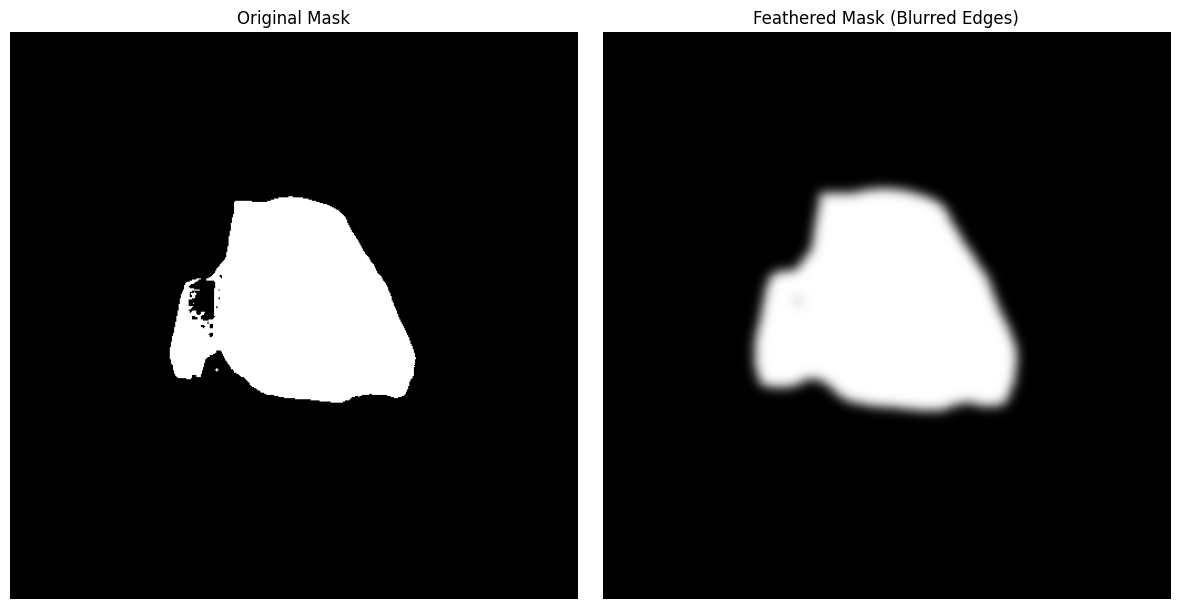

In [12]:
def feather_mask(mask, blur_amount=21):
    """
    Blurs the mask to create soft, 'feathered' edges.
    
    Args:
        mask (np.array): The input binary mask (0s and 255s).
        blur_amount (int): The size of the blur kernel. Must be an odd number.
                           Larger = softer/wider edge.
                           
    Returns:
        np.array: The grayscale feathered mask (values from 0-255).
    """
    # The kernel size for GaussianBlur must be odd
    if blur_amount % 2 == 0:
        blur_amount += 1
        
    # 'sigmaX=0' tells OpenCV to calculate the standard deviation from the kernel size
    feathered_mask = cv2.GaussianBlur(mask, (blur_amount, blur_amount), 0)
    return feathered_mask

# --- Example Usage ---
# Note: You often dilate *before* feathering for inpainting
dilated_for_feathering = dilate_mask(test_mask, kernel_size=15)
feathered = feather_mask(dilated_for_feathering, blur_amount=31)

compare_masks(test_mask, feathered, title2="Feathered Mask (Blurred Edges)")

--- Comparing Original vs. 'Hairy' (Jittered) ---


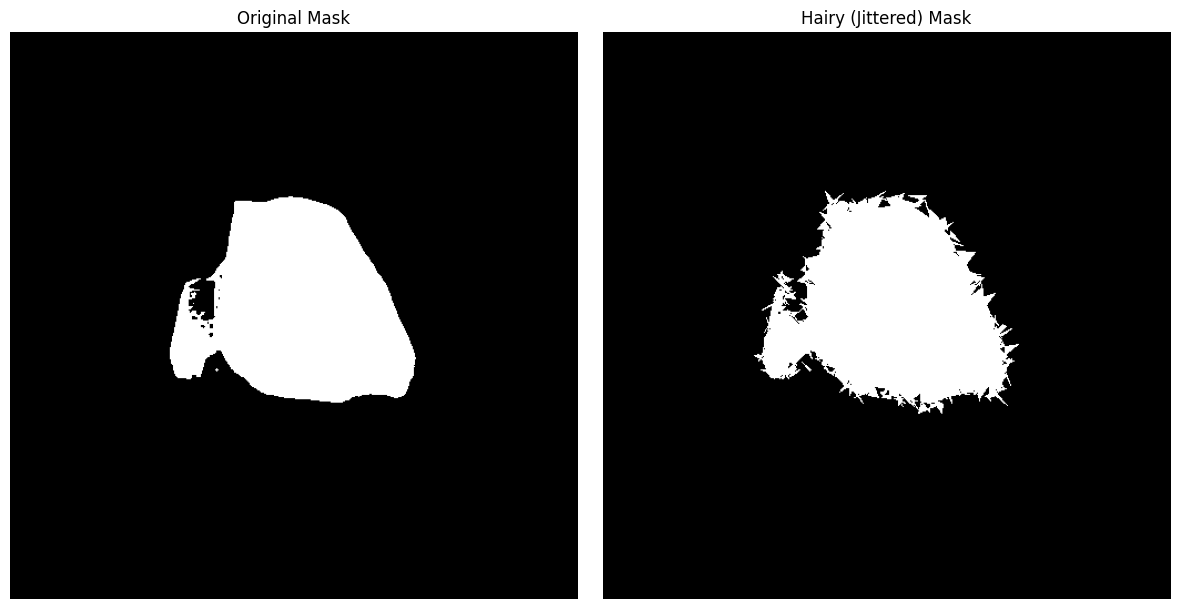

In [19]:
import random

def add_contour_jitter(mask, intensity=5, frequency=0.1):
    """
    Adds a "hairy" or "jagged" effect to a mask by jittering its contours.
    """
    
    # --- FIX: Ensure the mask is 1-channel (CV_8UC1) ---
    if len(mask.shape) == 3:
        # Convert to single-channel grayscale
        mask_8uc1 = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    else:
        # It's already 1-channel
        mask_8uc1 = mask
    # --- END FIX ---

    # Find contours on the 1-channel mask
    contours, hierarchy = cv2.findContours(mask_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Create a new black image to draw the hairy mask on
    hairy_mask = np.zeros_like(mask_8uc1) # Use the 1-channel mask's shape
    
    # Create a new list to hold our jittered contours
    jittered_contours = []
    
    for contour in contours:
        new_contour = contour.copy()
        
        # Go through each point (or a subset of points) in the contour
        for i in range(len(new_contour)):
            
            # Only apply jitter to a fraction of the points
            if random.random() < frequency:
                # Add random offset (jitter)
                offset_x = random.randint(-intensity, intensity)
                offset_y = random.randint(-intensity, intensity)
                
                new_contour[i][0][0] += offset_x  # Jitter X coordinate
                new_contour[i][0][1] += offset_y  # Jitter Y coordinate
                
        jittered_contours.append(new_contour)
    
    # Draw the new, jittered contours onto our black image
    cv2.drawContours(hairy_mask, jittered_contours, -1, (255), cv2.FILLED)
    
    return hairy_mask

# --- Example Usage ---
# This should work now, even if test_mask is 3-channel
hairy = add_contour_jitter(test_mask, intensity=10, frequency=0.3)

print("--- Comparing Original vs. 'Hairy' (Jittered) ---")
compare_masks(test_mask, hairy, title2="Hairy (Jittered) Mask")

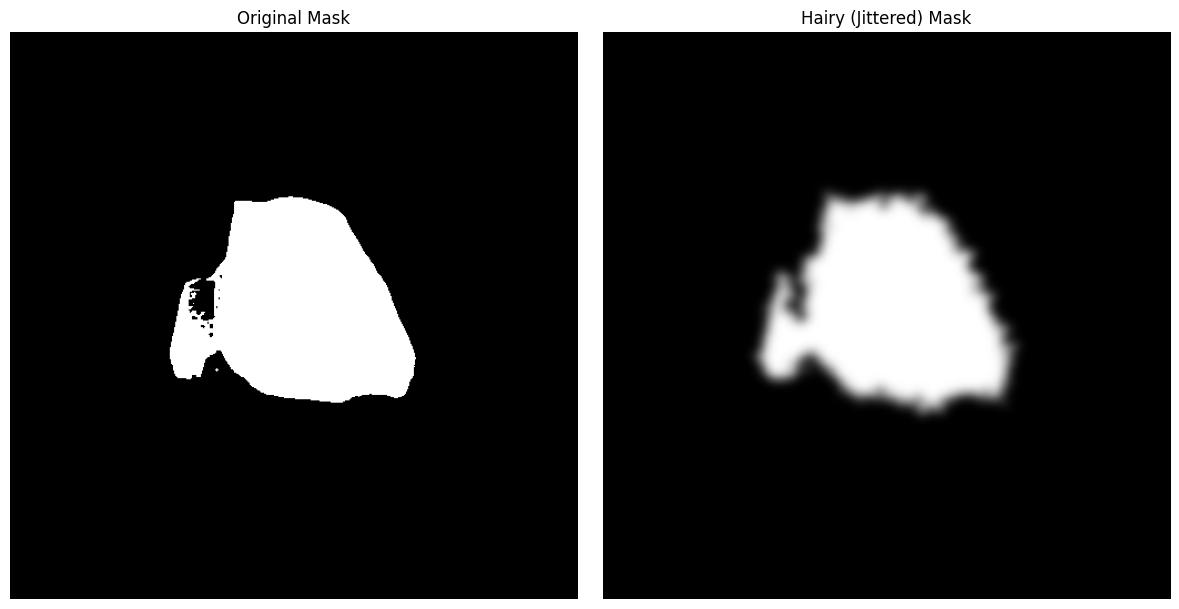

In [ ]:
hairy_ = feather_mask(hairy, blur_amount=31)
compare_masks(test_mask, hairy_, title2="Hairy and feathered Mask")


--- Comparing Original vs. 'Spiky' (Noise + Dilate) ---


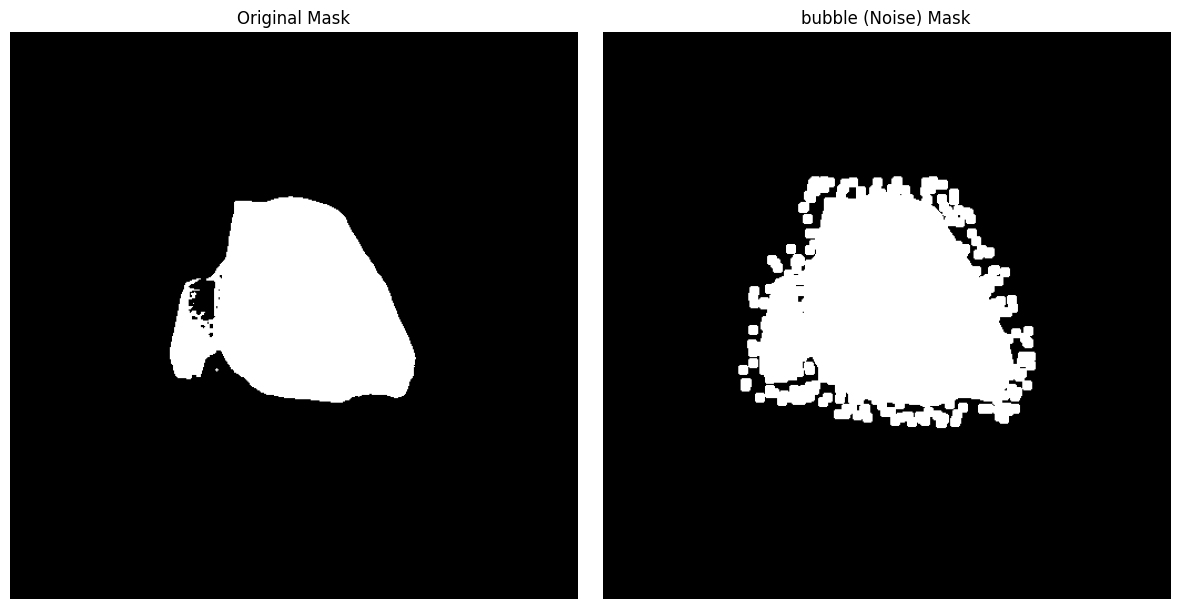

In [24]:
def add_spiky_noise(mask, speckle_count=200, speckle_range=50, dilate_kernel=5):
    """
    Adds a "spiky" effect by adding noise speckles and then dilating.
    """
    
    # --- FIX: Ensure the mask is 1-channel (CV_8UC1) ---
    if len(mask.shape) == 3:
        mask_8uc1 = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    else:
        mask_8uc1 = mask
    # --- END FIX ---
    
    # 1. Find the "edge" of the mask by eroding it and subtracting
    eroded = cv2.erode(mask_8uc1, np.ones((3,3), np.uint8), iterations=2)
    edge_region = mask_8uc1 - eroded
    
    # 2. Dilate this edge region to get a "zone" to add noise
    noise_zone = cv2.dilate(edge_region, np.ones((speckle_range, speckle_range), np.uint8))

    # 3. Get all (y, x) coordinates where we're allowed to add noise
    noise_coords = np.where(noise_zone == 255)
    
    # 4. Create a noise image
    noise_image = np.zeros_like(mask_8uc1)
    
    if len(noise_coords[0]) > 0:
        for _ in range(speckle_count):
            # Pick a random index from the allowed coordinates
            idx = random.randint(0, len(noise_coords[0]) - 1)
            
            y = noise_coords[0][idx]
            x = noise_coords[1][idx]
            
            # Add a white speckle
            cv2.circle(noise_image, (x, y), 1, (255), -1)

    # 5. Combine the original mask with the noise speckles
    combined_mask = cv2.bitwise_or(mask_8uc1, noise_image)
    
    # 6. Dilate the combined mask to connect the speckles
    # We can re-use the dilate_mask function we defined earlier
    spiky_mask = dilate_mask(combined_mask, kernel_size=dilate_kernel)
    
    return spiky_mask

# --- Example Usage ---
spiky = add_spiky_noise(test_mask, speckle_count=500, speckle_range=40, dilate_kernel=7)

print("\n--- Comparing Original vs. 'Spiky' (Noise + Dilate) ---")
compare_masks(test_mask, spiky, title2="bubble (Noise) Mask")

PyMatting 

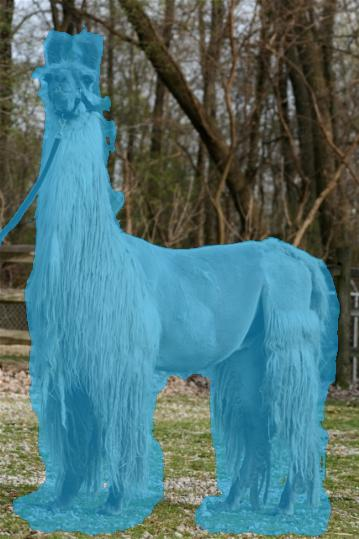
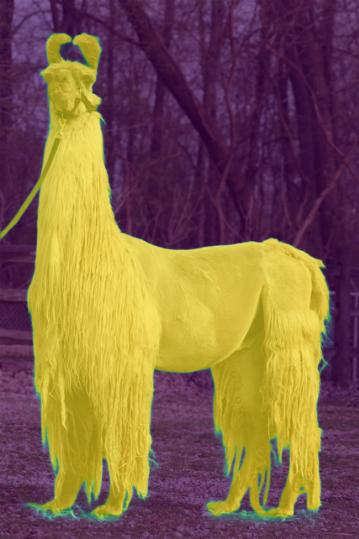